# OptiCoffee

El Área de Producción de **OptiCoffee** lo ha contactado para realizar la **planeación de la producción de toneladas de café para los próximos 12 meses**. El Área de Producción debe decidir **cuántas toneladas de café producir mensualmente** con el fin de **satisfacer la demanda al final de cada mes**.

Actualmente, OptiCoffee cuenta con un **inventario de 100 toneladas** de café almacenadas en su bodega. Al final de cada mes, el café que no haya sido utilizado debe ser **almacenado en inventario** y puede ser utilizado para satisfacer la demanda de los siguientes meses.

La **Tabla 1** presenta los **costos mensuales de producción y almacenamiento** de una tonelada de café, así como la **demanda mensual** de toneladas de café que tiene que satisfacer OptiCoffee. Es importante tener en cuenta que los **costos y la demanda varían dependiendo del mes**.

Naturalmente, el Área de Producción de OptiCoffee desea **minimizar sus costos totales a lo largo del horizonte de planeación** (i.e., 12 meses).



**Tabla 1.** Costos mensuales de producción y almacenamiento de una tonelada de café y demanda mensual

| Mes                                               | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10  | 11  | 12  |
| ------------------------------------------------- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Costo de producción** (millones de COP/Ton)     | 5   | 5   | 5   | 10  | 6   | 10  | 9   | 9   | 6   | 10  | 7   | 8   |
| **Costo de almacenamiento** (millones de COP/Ton) | 5   | 4   | 4   | 5   | 3   | 1   | 3   | 5   | 3   | 3   | 4   | 5   |
| **Demanda** (Ton)                                 | 522 | 554 | 557 | 519 | 476 | 475 | 462 | 452 | 465 | 422 | 512 | 596 |



**Objetivo**

Para planear la producción de OptiCoffee, usted desarrollará un **modelo de optimización**.

## Datos

In [25]:
import time



import sys
import os

sys.path.append(os.path.abspath("../Instances"))

from InsInventory import generar_datos



resultados = []

In [26]:
# Crear entorno con instancia sintética
horizonte_planeacion = generar_datos(num_periodos=12)
I_0 = int(min(horizonte_planeacion['d_t']) * 0.25)
horizonte_planeacion


,t,Mes,c_t,h_t,d_t,Clasif_c,Clasif_h,Demanda_rel
t,,,,,,,,
1,1,ENE,4.40,3.50,5,Barato,Medio,Media
2,2,FEB,5.13,4.67,5,Barato,Medio,Media
3,3,MAR,4.77,1.75,5,Barato,Barato,Media
4,4,ABR,8.03,6.58,7,Caro,Caro,Alta
5,5,MAY,5.85,4.58,3,Barato,Medio,Baja
6,6,JUN,4.38,3.96,5,Barato,Medio,Media
7,7,JUL,6.42,1.43,5,Medio,Barato,Media
8,8,AGO,11.15,7.60,4,Caro,Caro,Baja
9,9,SEP,9.66,5.88,4,Caro,Caro,Baja


## Optimización (MIP)

### Formulación

#### Conjuntos

$$
M \quad \text{: Conjunto de meses}
$$

#### Parámetros

$$
c_t \quad \text{: Costo de producir una tonelada de café en el mes } t \in M
$$

$$
h_t \quad \text{: Costo de almacenar una tonelada de café en el mes } t \in M
$$

$$
d_t \quad \text{: Demanda de café en el mes } t \in M
$$

$$
I^0 \quad \text{: Inventario inicial (toneladas)}
$$


#### Variables de decisión

$$
x_t \quad \text{: Toneladas de café a producir en el mes } t \in M
$$

$$
I_t \quad \text{: Inventario de toneladas de café al final del mes } t \in M
$$


#### Modelo en Palabras

**Minimizar:**

> Costos de producción + Costos de almacenamiento

**Sujeto a:**

* Modelar el inventario para el primer mes
* Modelar el inventario para los demás meses
* Naturaleza de las variables

#### Modelo Matemático

Minimizar:

$$
\sum_{t \in M} (c_t x_t + h_t I_t) \tag{1}
$$

Sujeto a:

Inventario en el primer mes:

$$
I_1 = I^0 + x_1 - d_1 \tag{2}
$$

Inventario para los meses siguientes:

$$
I_t = I_{t-1} + x_t - d_t, \quad \forall t \in M \mid t > 1 \tag{3}
$$

Naturaleza de las variables:

$$
x_t, I_t \geq 0, \quad \forall t \in M \tag{4}
$$

#### Notas

* (1) minimiza los costos de producción más los costos de almacenamiento.
* (2) modela el inventario para el primer mes.
* (3) modela el inventario para los demás meses.
* (4) describe la naturaleza de las variables.


In [27]:
M = list(horizonte_planeacion.index)
c = dict(horizonte_planeacion['c_t'].squeeze())
h = dict(horizonte_planeacion['h_t'].squeeze())
d = dict(horizonte_planeacion['d_t'].squeeze())

In [28]:
import pulp as lp

def optimizacion_inventario(M, c, h, d, I_0 = 0):

    model = lp.LpProblem("OptiCoffi", lp.LpMinimize)

    x = {t: lp.LpVariable(f'x_{t}', lowBound=0, cat=lp.LpInteger) for t in M}
    I = {t: lp.LpVariable(f'I_{t}', lowBound=0, cat=lp.LpInteger) for t in M}
    
    model += lp.lpSum(c[t] * x[t] + h[t] * I[t] for t in M)

    for t in M:
        if t == 1:
            model += I[1] == I_0 + x[1] - d[1]
        else:
            model += I[t] == I[t-1] + x[t] - d[t]
    
    solver = lp.getSolver('PULP_CBC_CMD', msg=False)
    model.solve(solver)

    print(f'El optimizador llegó a una solución: {lp.LpStatus[model.status]}.')

    return model, x, I

In [29]:
t0 = time.perf_counter()

model, x, I = optimizacion_inventario(M, c, h, d, I_0)

elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")


obj_lp = round(lp.value(model.objective), 3)

produccion = {t: x[t].varValue for t in M}
inventario = {1: I_0, **{t+1: I[t].varValue for t in M}}

cost_produccion = round(sum([x[t].varValue * c[t] for t in M]), 3)
cost_inventario = round(sum([I[t].varValue * h[t] for t in M]), 3)


print(f'FO (valor total): {cost_produccion} (Producción) + {cost_inventario} (Inventario) = {obj_lp}')
print(f'Cantidad de toneladas pedidas (valor total): {sum(produccion.values())}.')
print(f'Cantidad de toneladas en inventario (valor total): {sum(inventario.values())}.')

resultados.append({
    "Método"             : "LP",
    "Costo Total"        : obj_lp,
    "Costo producir"     : cost_produccion,
    "Costo inventario"   : cost_inventario,
    "Ton pedidas (total)": sum(produccion.values()),
    "Inventario(total)"  : sum(inventario.values()),
    "Tiempo (s)"         : elapsed
})

El optimizador llegó a una solución: Optimal.

Tiempo de ejecución: 0.039316 s
FO (valor total): 379.28 (Producción) + 31.05 (Inventario) = 410.33
Cantidad de toneladas pedidas (valor total): 59.0.
Cantidad de toneladas en inventario (valor total): 17.0.


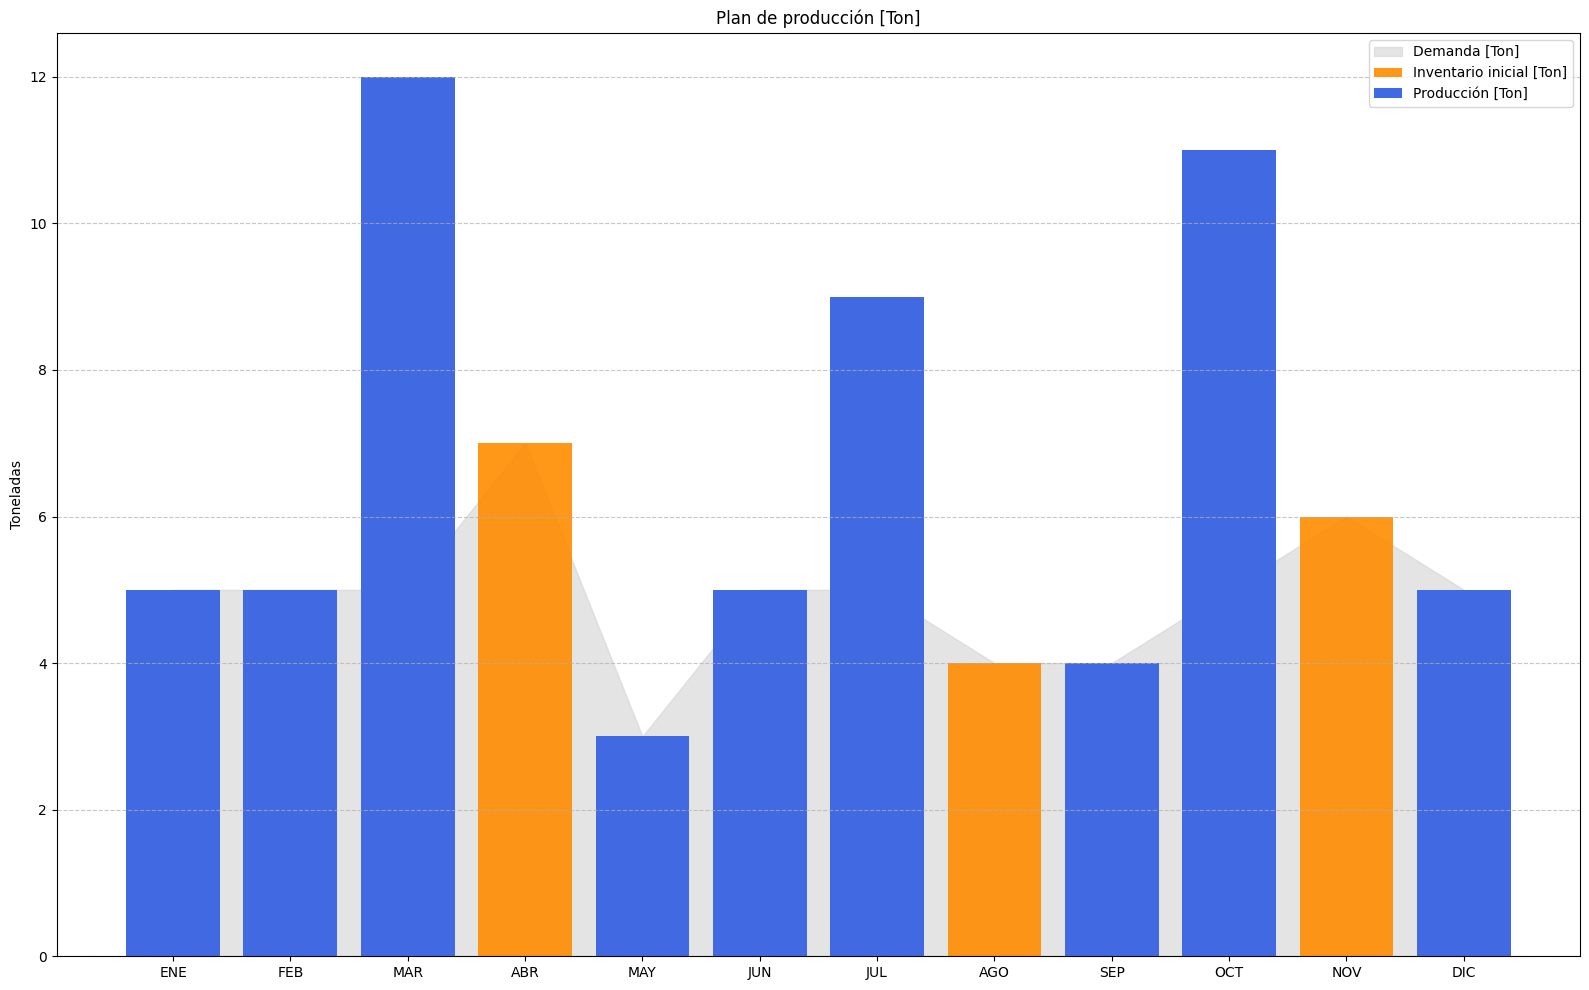

In [30]:
import matplotlib.pyplot as plt

if len(M) <= 12:
    meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
    meses = meses[:len(M)]
else:
    meses = [f"M{i}" for i in M]

# Extraer datos en listas
demanda_list = [d[t] for t in M]
produccion_list = [produccion[t] for t in M]
inventario_list = [inventario[t] for t in M]

# Graficar correctamente con barras apiladas
plt.figure(figsize=(16, 10))

# Área de la demanda
plt.fill_between(meses, demanda_list, color='lightgray', label='Demanda [Ton]', alpha=0.6)

# Barras apiladas: producción sobre inventario inicial
plt.bar(meses, inventario_list, label='Inventario inicial [Ton]', color='darkorange', alpha=0.9)
plt.bar(meses, produccion_list, bottom=inventario_list, label='Producción [Ton]', color='royalblue')

plt.title('Plan de producción [Ton]')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Programación Dinámica

### Algoritmos de Solución

In [31]:
sys.path.append(os.path.abspath("../DP/Env"))
sys.path.append(os.path.abspath("../DP/Algorithms/"))
sys.path.append(os.path.abspath("../DP/Visual/"))

from Inventory import InventoryEnv

from value_iteration import value_iteration
from policy_evaluation import policy_evaluation
from policy_iteration import policy_iteration

from value_states import value_states_visual
from policy_dag import draw_policy_dag

#### Datos

In [32]:
# 1. Definimos la demanda determinística para n períodos
demand = list(d.values())
cost_producir = list(c.values())
cost_almacenar = list(h.values())

# 2. Fijamos los parámetros del almacén
capacity         = int(sum(demand)/2)
start_inventory  = I_0


env = InventoryEnv(demand, cost_producir, cost_almacenar, capacity, start_inventory)
print(env)

InventoryEnv(Horizonte = 12, Capacidad = 29, #_Estados = 390)


#### Policy Evaluation


Tiempo de ejecución: 0.002452 s
FO (valor total): 441.36 (Producción) + 0.0 (Inventario) = 441.36
Cantidad de toneladas pedidas (valor total): 59.
Cantidad de toneladas en inventario (valor total): 0.


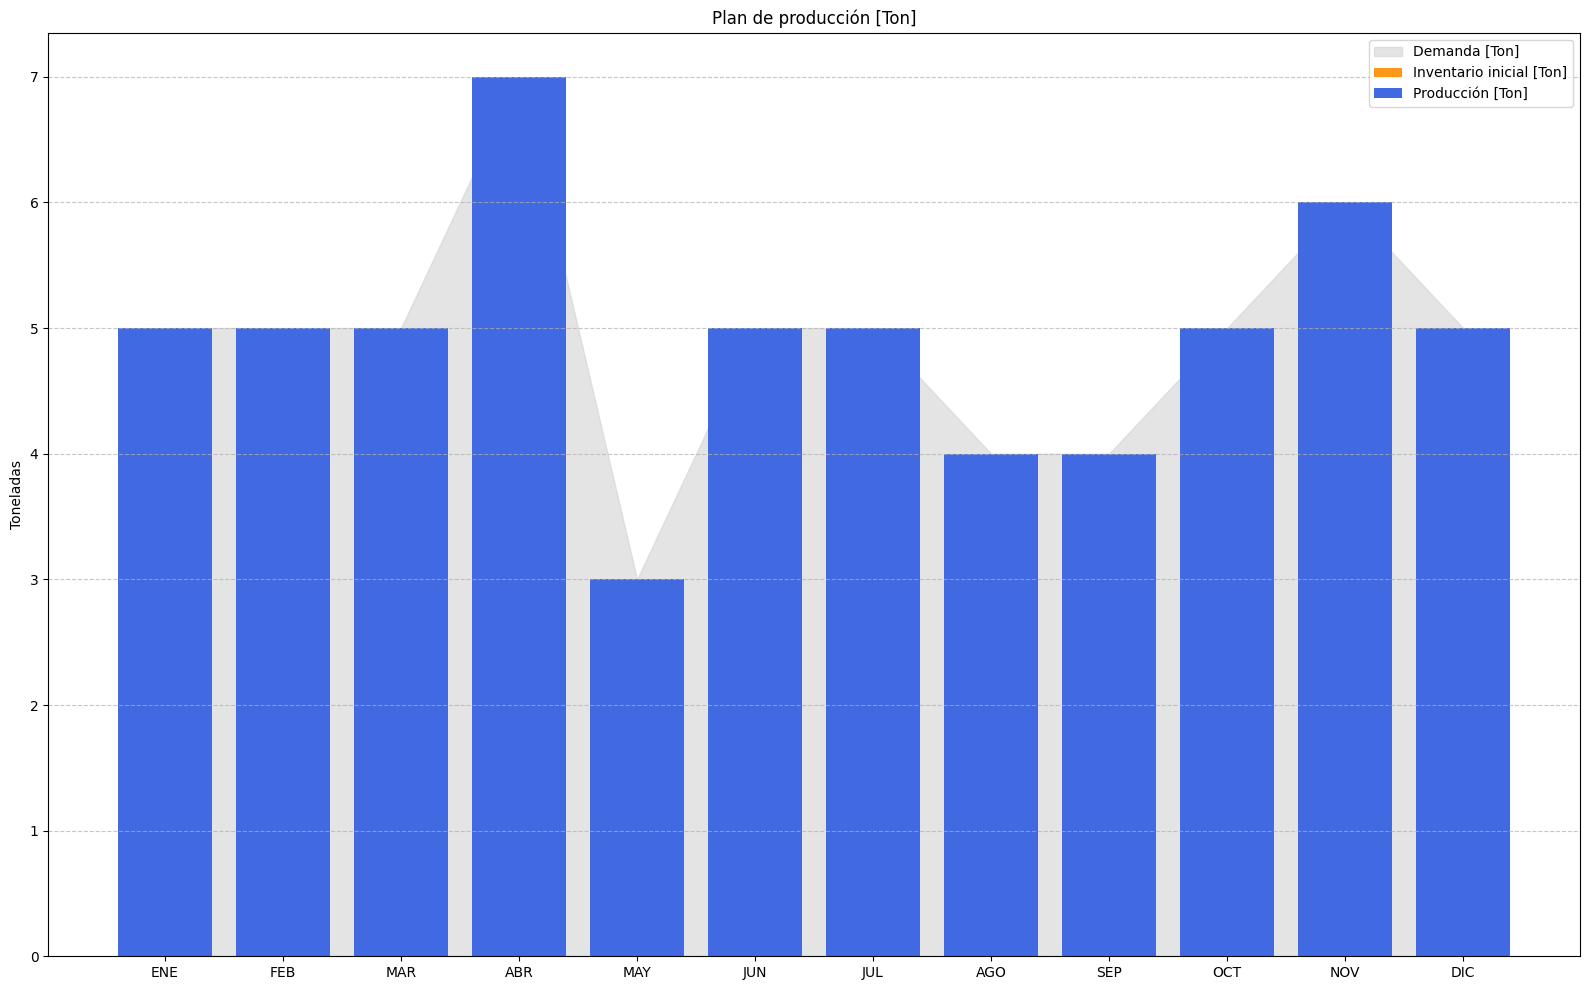

In [33]:
# Politica

propose_policy = { (t, S): max(0, env.demand[t] - S)
           for t in range(env.n)
           for S in range(env.capacity + 1) }

policy = propose_policy.copy()



t0 = time.perf_counter()

# ▸ Evaluación de la política determinista 'propose_policy'
V = policy_evaluation(env, propose_policy)

elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

obj_lp, costos_prod, costos_inv, produccion, inventario, trayecto = env.report_from_policy(policy)

resultados.append({
    "Método"             : "Policy evaluation",
    "Costo Total"        : obj_lp,
    "Costo producir"     : sum(costos_prod),
    "Costo inventario"   : sum(costos_inv),
    "Ton pedidas (total)": sum(produccion),
    "Inventario(total)"  : sum(inventario),
    "Tiempo (s)"         : elapsed
})

#### Policy Iteration


Tiempo de ejecución: 0.012064 s
FO (valor total): 379.28 (Producción) + 31.05 (Inventario) = 410.33
Cantidad de toneladas pedidas (valor total): 59.
Cantidad de toneladas en inventario (valor total): 17.


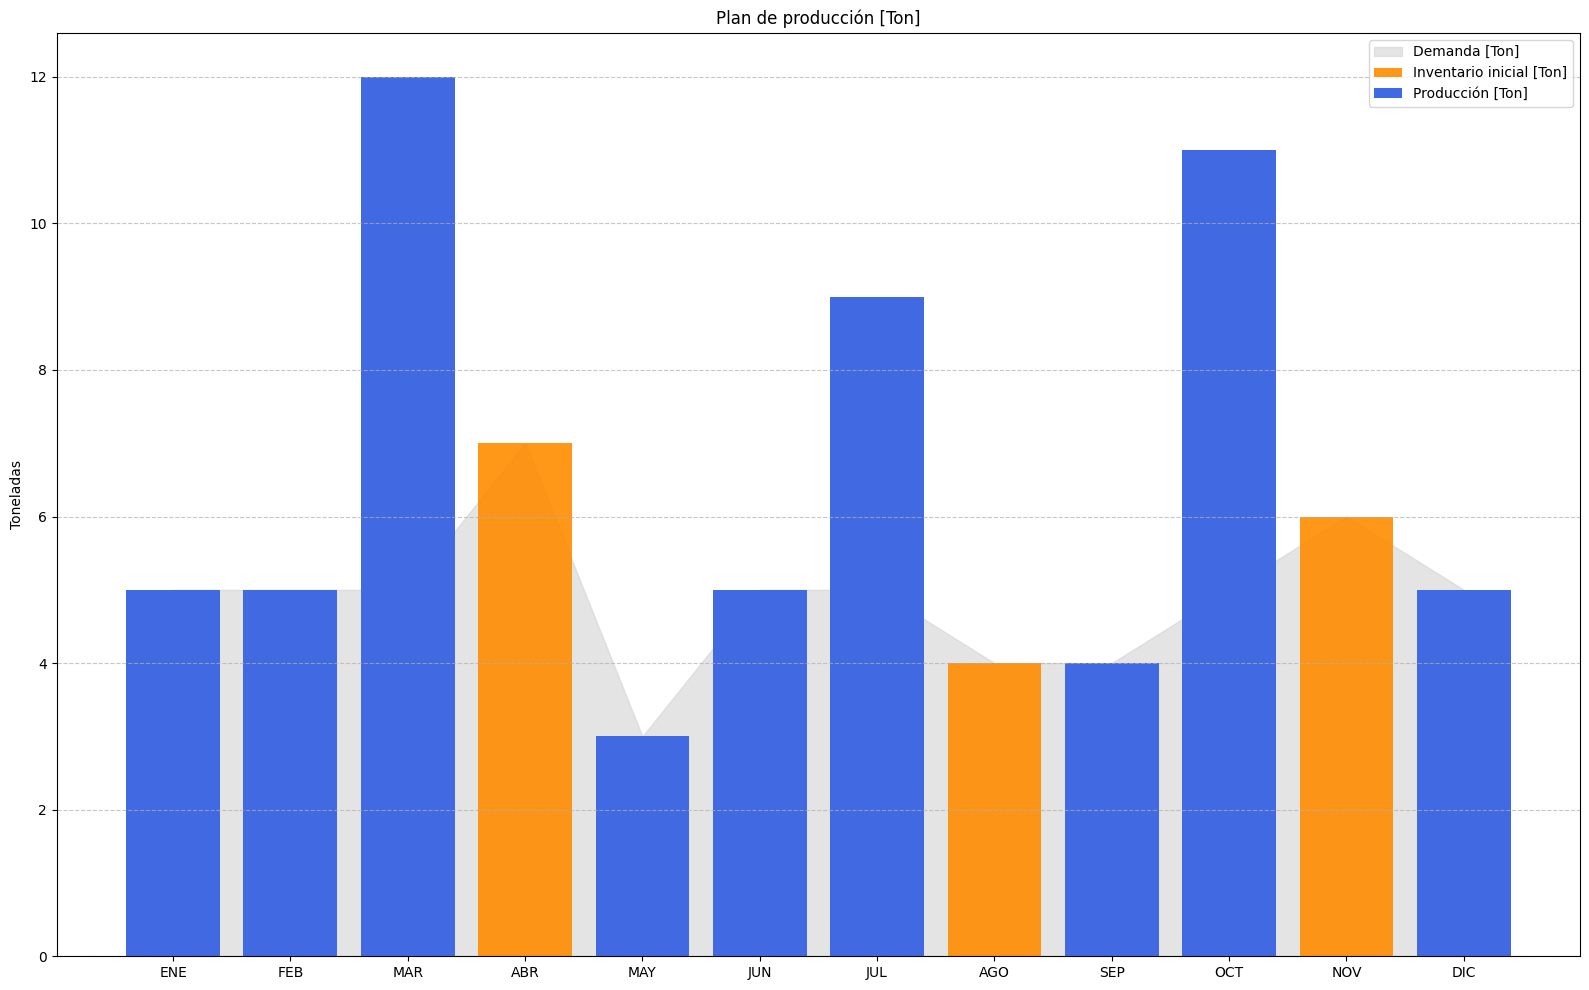

In [34]:
t0 = time.perf_counter()

star_policy, V_star = policy_iteration(env, policy)

elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

obj_lp, costos_prod, costos_inv, produccion, inventario, trayecto = env.report_from_policy(star_policy)

resultados.append({
    "Método"             : "Policy iteration",
    "Costo Total"        : obj_lp,
    "Costo producir"     : sum(costos_prod),
    "Costo inventario"   : sum(costos_inv),
    "Ton pedidas (total)": sum(produccion),
    "Inventario(total)"  : sum(inventario),
    "Tiempo (s)"         : elapsed
})

#### Value Iteration


Tiempo de ejecución: 0.051178 s
FO (valor total): 379.28 (Producción) + 31.05 (Inventario) = 410.33
Cantidad de toneladas pedidas (valor total): 59.
Cantidad de toneladas en inventario (valor total): 17.


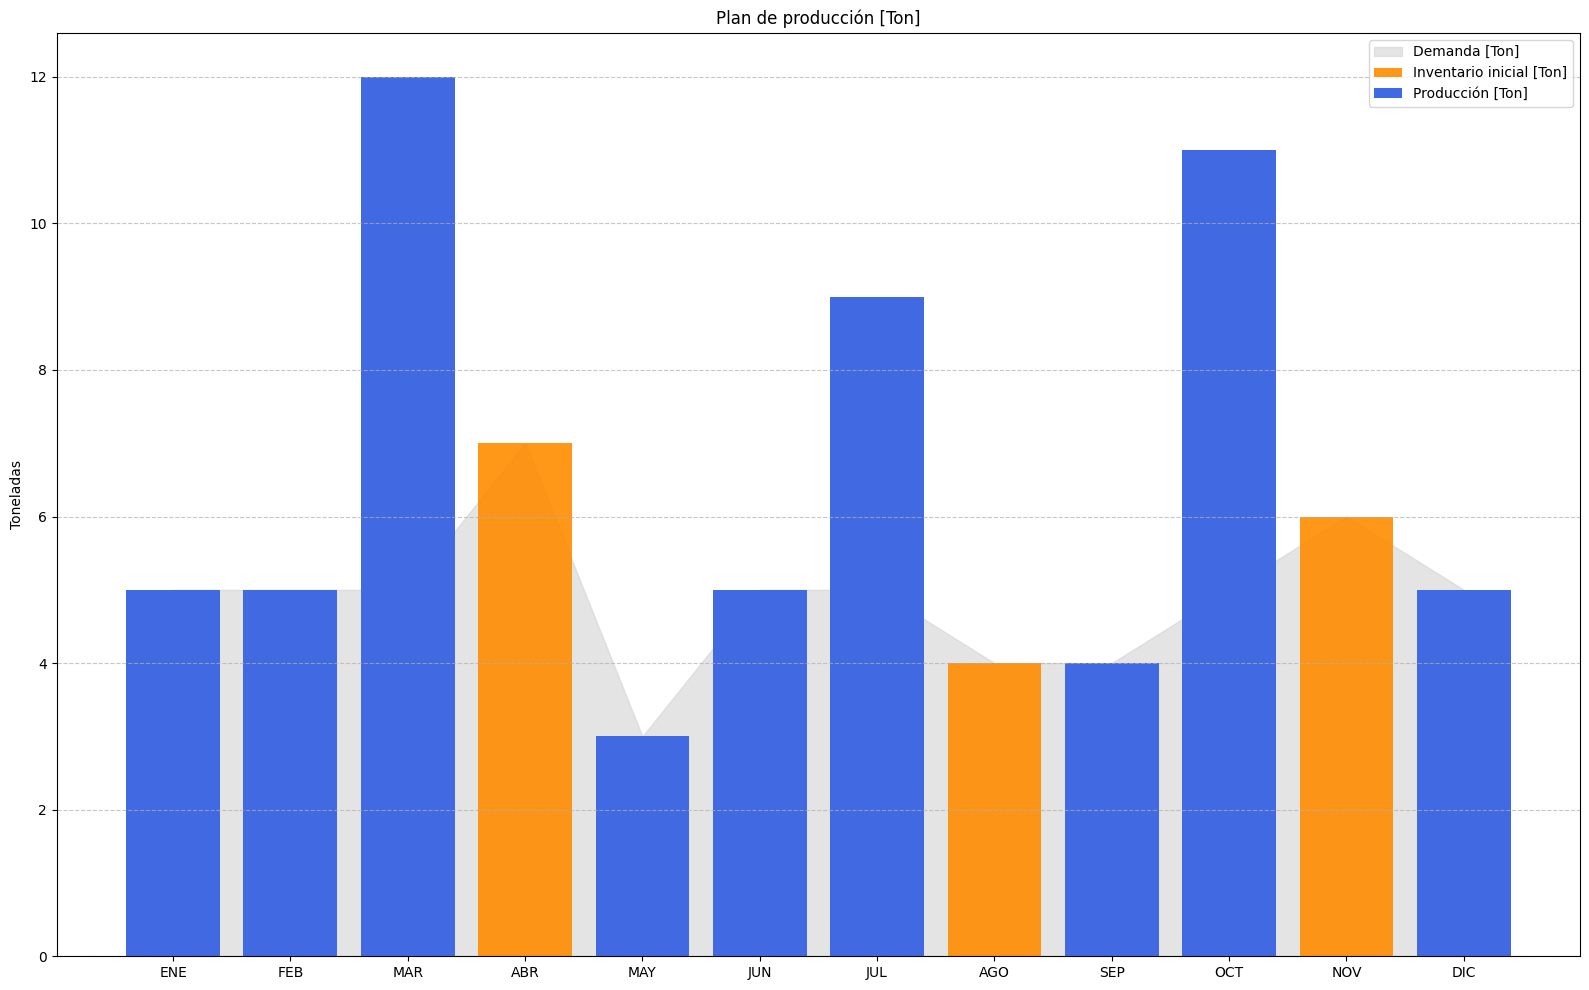

In [35]:
t0 = time.perf_counter()


opt_policy, V_opt = value_iteration(env)

elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

obj_lp, costos_prod, costos_inv, produccion, inventario, trayecto = env.report_from_policy(opt_policy)

resultados.append({
    "Método"             : "Value iteration",
    "Costo Total"        : obj_lp,
    "Costo producir"     : sum(costos_prod),
    "Costo inventario"   : sum(costos_inv),
    "Ton pedidas (total)": sum(produccion),
    "Inventario(total)"  : sum(inventario),
    "Tiempo (s)"         : elapsed
})

### Visualización

#### Value Functions

In [36]:
# ============================================================================
# Visualización condicional de V(s) para cada método aplicado
# ============================================================================
# Se muestran mapas de calor solo si el número de ítems (env.n) es razonable.
# Esto evita congestión visual en instancias grandes.
# ============================================================================

if env.capacity <= 15:

    # ----------------------------------------------------------------------
    # Evaluación de política heurística
    # ----------------------------------------------------------------------
    print("Policy Evaluation")
    value_states_visual(env, V, propose_policy)
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de políticas
    # ----------------------------------------------------------------------
    print("Policy Iteration")
    value_states_visual(env, V_star, star_policy)
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de valores
    # ----------------------------------------------------------------------
    print("Value Iteration")
    value_states_visual(env, V_opt, opt_policy)
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")


Para visualizar, use una instancia más pequeña.


#### Policy

In [37]:
# ============================================================================
# Visualización condicional del DAG de decisiones para cada política evaluada
# ============================================================================
# Dibuja el grafo dirigido de estados con la trayectoria tomada por:
#   • Política heurística
#   • Iteración de políticas
#   • Iteración de valores
# Solo se activa para instancias pequeñas (n ≤ 20).
# ============================================================================

if env.capacity <= 15:

    # ----------------------------------------------------------------------
    # Política heurística: tomar cuando sea legal
    # ----------------------------------------------------------------------
    print("Policy Evaluation")
    draw_policy_dag(env, propose_policy, initial_state=(0, env.start_inventory))
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de políticas
    # ----------------------------------------------------------------------
    print("Policy Iteration")
    draw_policy_dag(env, star_policy, initial_state=(0, env.start_inventory))
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de valores
    # ----------------------------------------------------------------------
    print("Value Iteration")
    draw_policy_dag(env, opt_policy, initial_state=(0, env.start_inventory))
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")


Para visualizar, use una instancia más pequeña.


## Heurísticas

### EOQ

In [38]:
import math

def heuristica_eoq(M, d, I_0, EOQ,debug=False):
    """
    Heurística tipo EOQ en horizonte discreto con demanda variable.
    Devuelve inventario *inicial* por período (útil para graficar barras apiladas
    inventario+producción), y opcionalmente inventario final.

    Parámetros
    ----------
    M : list ordenada de períodos (ej. [1,2,...,12]).
    c, h, d : dict por período.
    I_0 : inventario inicial antes del primer período de M.
    EOQ : tamaño de lote objetivo (trigger para agrupar períodos).
    metodo_name : etiqueta para registro en `resultados`.
    debug : imprime trazas.
    agregar_a_resultados : si existe lista global `resultados`, registrar.
    return_inv_final : si True, retorna también dict con inventario final.

    Returns
    -------
    obj_lp, produccion, inventario_ini   [y opcional inv_final]
    """
    n = len(M)
    produccion = {t: 0 for t in M}
    inventario_ini = {}   # lo que graficarás en naranja (antes de producir en t)
    inventario_fin = {}   # usado para costos de holding

    inv = I_0  # inventario disponible al inicio del período actual
    idx = 0

    while idx < n:
        t_ini = M[idx]

        # registrar inventario inicial del período de inicio de lote (antes de producir)
        inventario_ini[t_ini] = inv

        # agrupar períodos hasta alcanzar EOQ o agotar horizonte
        demanda_acum = 0
        k = 0
        while idx + k < n and demanda_acum < EOQ:
            demanda_acum += d[M[idx + k]]
            k += 1
        # si se alcanzó el final, k ya cubre lo que queda; demanda_acum ya suma eso

        # cantidad a producir para cubrir demanda del lote dado inv disponible
        q = max(0, demanda_acum - inv)
        produccion[t_ini] += q
        inv += q  # producción disponible inmediatamente

        if debug:
            print(f"\n[Lote inicia en {t_ini}] inv_ini={inventario_ini[t_ini]}  demanda_lote={demanda_acum}  prod={q}")

        # consumir demanda período por período dentro del lote
        for j in range(k):
            t_cur = M[idx + j]

            # para períodos dentro del lote distintos del inicial, registrar inv inicial antes de consumo
            if j > 0:
                inventario_ini[t_cur] = inv  # lo que llega desde período anterior; no hay producción aquí

            inv -= d[t_cur]

            if inv < 0:  # no se permiten faltantes -> retro-ajustar producción en t_ini
                faltante = -inv
                if debug:
                    print(f"  Ajuste: faltante {faltante} detectado en {t_cur}; aumentando prod en {t_ini}.")
                produccion[t_ini] += faltante
                inv = 0  # después del ajuste, quedamos exactos

            inventario_fin[t_cur] = inv
            if debug:
                print(f"    Fin {t_cur}: inv_fin={inv}")

        # avanzar al siguiente lote
        idx += k

    # asegurar que todos los períodos tienen valores
    for t in M:
        inventario_ini.setdefault(t, 0)
        inventario_fin.setdefault(t, 0)
        produccion.setdefault(t, 0)

    return obj_lp, produccion, inventario_ini, inventario_fin

In [39]:

D_total = sum(d[t] for t in M)  # demanda total en el horizonte
H_prom  = sum(h[t] for t in M) / len(M)  # costo holding promedio
C_prom  = sum(c[t] for t in M) / len(M) 
EOQ = math.sqrt(2 * D_total * C_prom / H_prom)


t0 = time.perf_counter()
obj_lp, produccion, inventario, inventario_fin = heuristica_eoq(M, d, I_0, EOQ)
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")


# costos (usamos inventario final para holding)
cost_produccion = sum(produccion[t] * c[t] for t in M)
cost_inventario = sum(inventario_fin[t] * h[t] for t in M)
obj_lp = cost_produccion + cost_inventario

# imprimir
print(f'FO (valor total): {cost_produccion:.2f} (Producción) + {cost_inventario:.2f} (Inventario) = {obj_lp:.2f}')
print(f'Cantidad de toneladas producidas (valor total): {sum(produccion.values())}.')
print(f'Cantidad de toneladas en inventario (valor total): {sum(inventario_fin.values())}.')

# registrar
resultados.append({
                "Método"             : "EOQ",
                "Costo Total"        : obj_lp,
                "Costo producir"     : cost_produccion,
                "Costo inventario"   : cost_inventario,
                "Ton pedidas (total)": sum(produccion.values()),
                "Inventario(total)"  : sum(inventario_fin.values()),
                "Tiempo (s)"         : elapsed
            })



Tiempo de ejecución: 0.000039 s
FO (valor total): 420.37 (Producción) + 287.93 (Inventario) = 708.30
Cantidad de toneladas producidas (valor total): 59.
Cantidad de toneladas en inventario (valor total): 60.


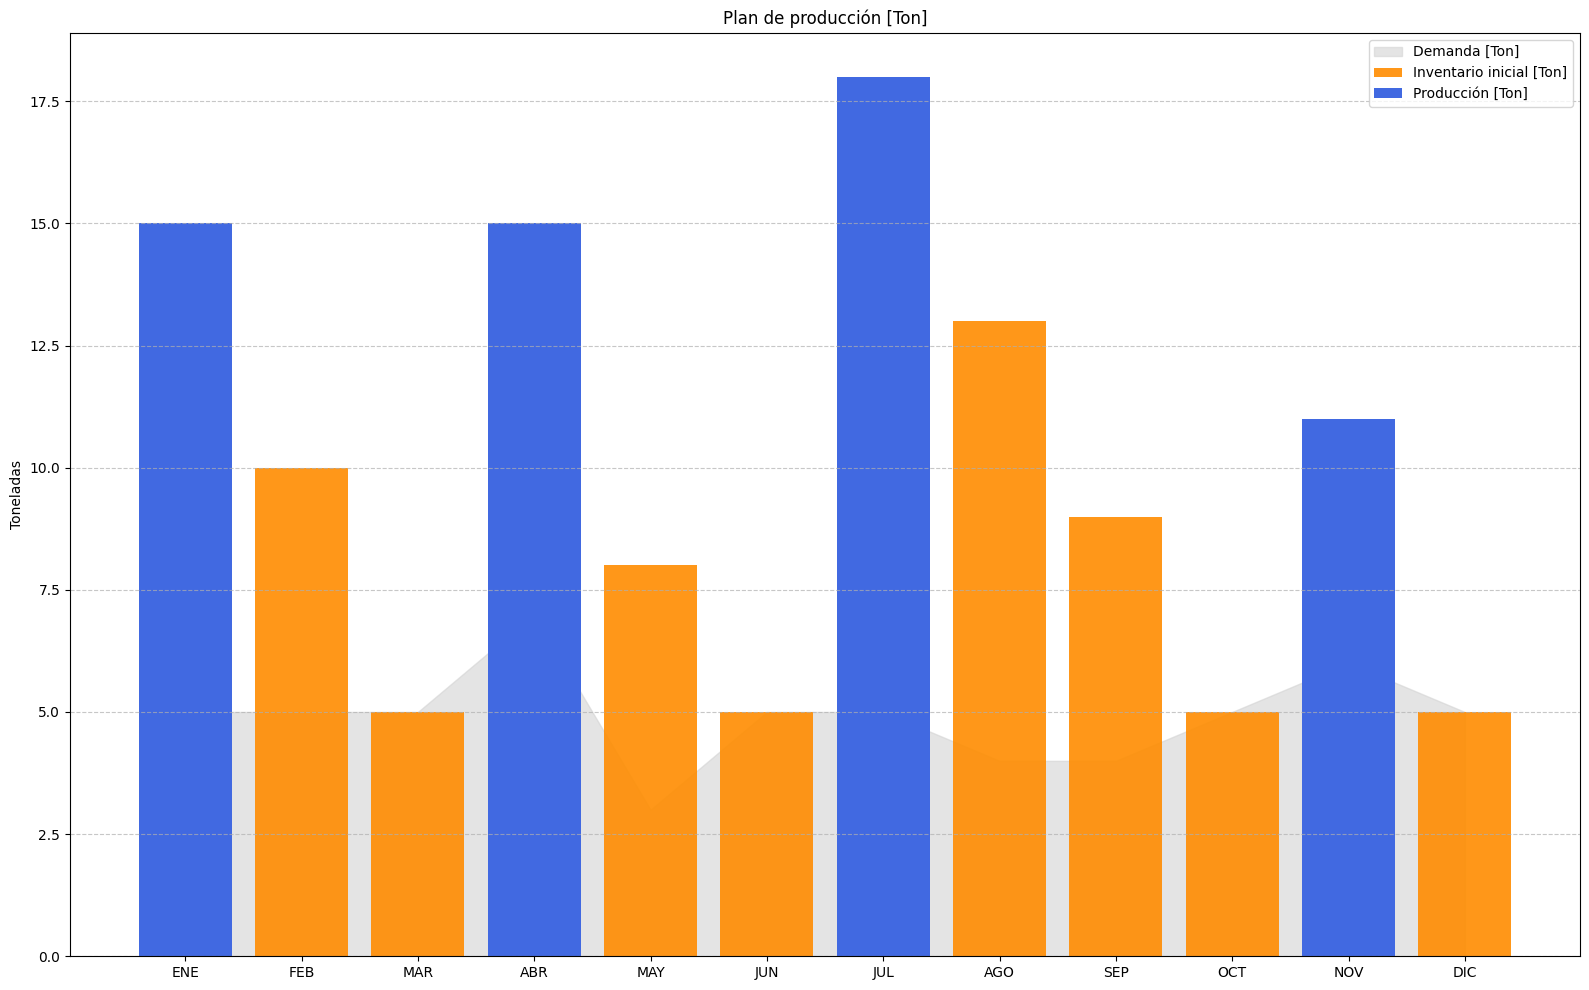

In [40]:
import matplotlib.pyplot as plt

if len(M) <= 12:
    meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
    meses = meses[:len(M)]
else:
    meses = [f"M{i}" for i in M]

# Extraer datos en listas
demanda_list = [d[t] for t in M]
produccion_list = [produccion[t] for t in M]
inventario_list = [inventario[t] for t in M]

# Graficar correctamente con barras apiladas
plt.figure(figsize=(16, 10))

# Área de la demanda
plt.fill_between(meses, demanda_list, color='lightgray', label='Demanda [Ton]', alpha=0.6)

# Barras apiladas: producción sobre inventario inicial
plt.bar(meses, inventario_list, label='Inventario inicial [Ton]', color='darkorange', alpha=0.9)
plt.bar(meses, produccion_list, bottom=inventario_list, label='Producción [Ton]', color='royalblue')

plt.title('Plan de producción [Ton]')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Política (s, S)

In [41]:
def heuristica_ss(M, d, I_0, s, S, debug=False,):

    produccion = {t: 0 for t in M}
    inventario_ini = {}
    inventario_fin = {}

    inv = I_0  # inventario que traigo al inicio del período

    for t in M:
        # registrar inventario inicial (lo que graficarás)
        inventario_ini[t] = inv

        # ¿gatilla producción?
        if inv < s:
            q = S - inv  # reponer hasta S
        else:
            q = 0

        # ¿Aún no alcanza para cubrir la demanda de este período?
        if inv + q < d[t]:
            q += d[t] - (inv + q)  # producir lo extra necesario para cubrir demanda

        produccion[t] = q
        inv += q  # producción disponible antes de atender demanda

        # consumir demanda
        inv -= d[t]

        # seguridad adicional (numérica): jamás negativo
        if inv < 0:
            if debug:
                print(f"Ajuste tardío en {t}: faltante {-inv}; incrementando producción.")
            produccion[t] += -inv
            inv = 0

        inventario_fin[t] = inv

        if debug:
            print(f"t={t} inv_ini={inventario_ini[t]} prod={produccion[t]} demanda={d[t]} inv_fin={inventario_fin[t]}")

    return obj_lp, produccion, inventario_ini, inventario_fin



In [42]:
s = max(d.values())             # umbral mínimo
S = 1.5 * min(d.values())         # nivel al que se repone

t0 = time.perf_counter()
obj_lp, produccion, inventario, inventario_fin = heuristica_ss(M, d, I_0, s, S)
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# Calcular costos
cost_produccion = sum(produccion[t] * c[t] for t in M)
cost_inventario = sum(inventario[t] * h[t] for t in M)
obj_lp = cost_produccion + cost_inventario

# Imprimir resultados
print(f'FO (valor total): {cost_produccion:.2f} (Producción) + {cost_inventario:.2f} (Inventario) = {obj_lp:.2f}')
print(f'Cantidad de toneladas producidas (valor total): {sum(produccion.values())}.')
print(f'Cantidad de toneladas en inventario (valor total): {sum(inventario.values())}.')

# Guardar resultados
resultados.append({
        "Método"             : f"(s,S)",
        "Costo Total"        : obj_lp,
        "Costo producir"     : cost_produccion,
        "Costo inventario"   : cost_inventario,
        "Ton pedidas (total)": sum(produccion.values()),
        "Inventario(total)"  : sum(inventario.values()),
        "Tiempo (s)"         : elapsed
})


Tiempo de ejecución: 0.000028 s
FO (valor total): 445.46 (Producción) + 9.97 (Inventario) = 455.43
Cantidad de toneladas producidas (valor total): 59.0.
Cantidad de toneladas en inventario (valor total): 2.5.


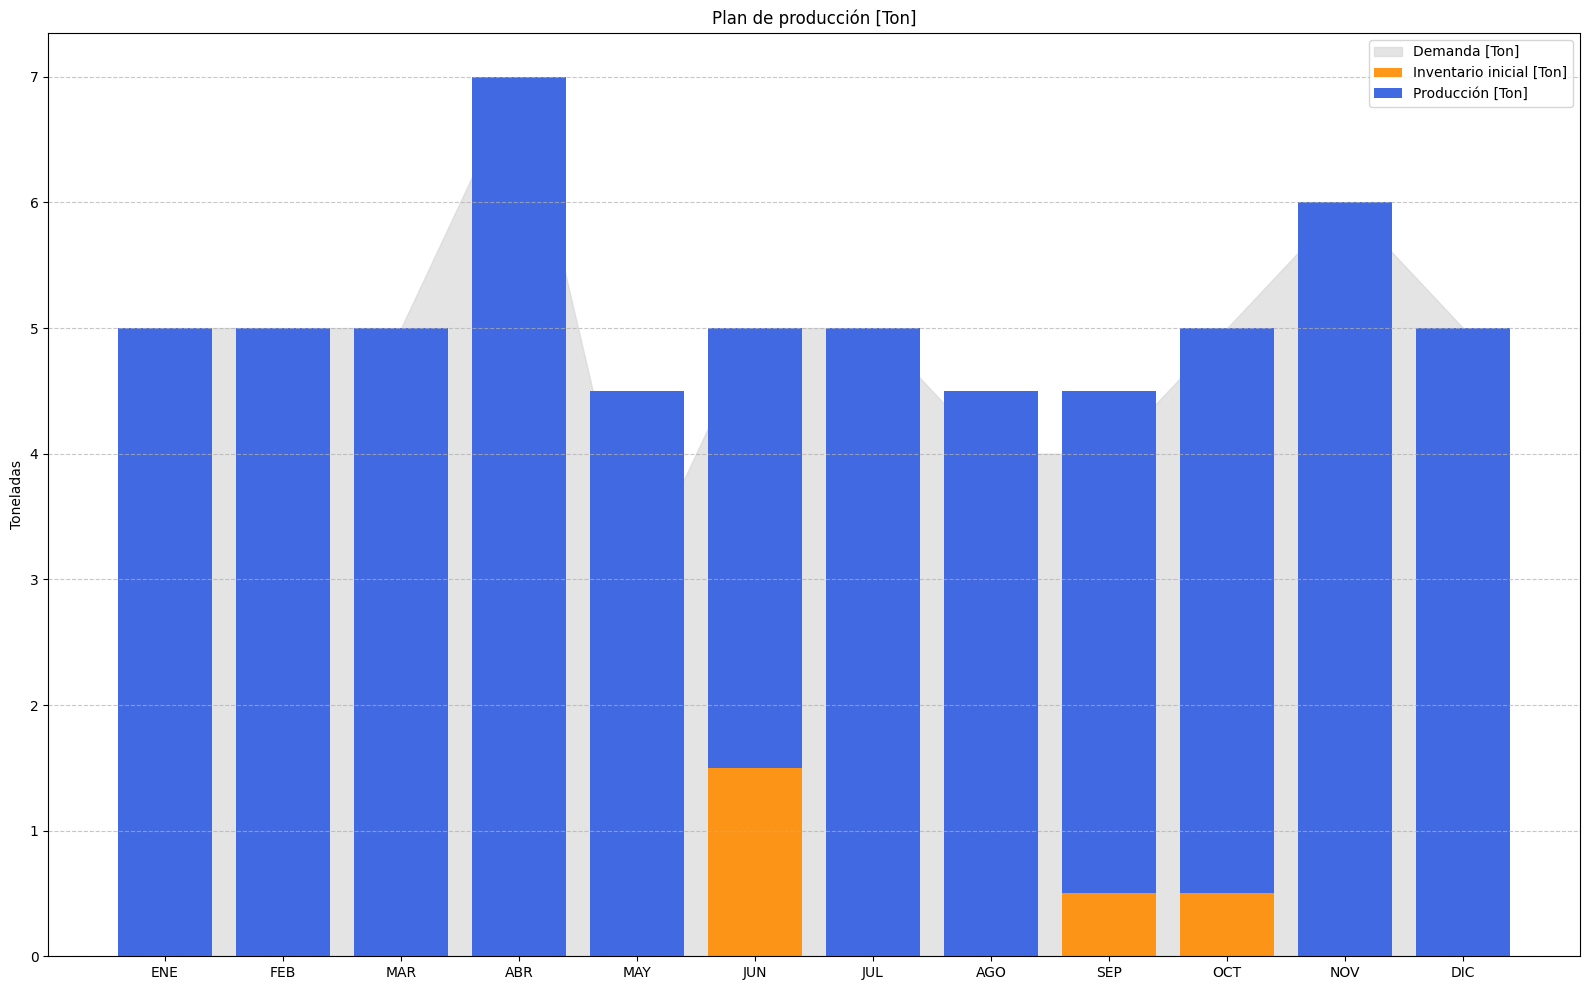

In [43]:
import matplotlib.pyplot as plt

if len(M) <= 12:
    meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
    meses = meses[:len(M)]
else:
    meses = [f"M{i}" for i in M]

# Extraer datos en listas
demanda_list = [d[t] for t in M]
produccion_list = [produccion[t] for t in M]
inventario_list = [inventario[t] for t in M]

# Graficar correctamente con barras apiladas
plt.figure(figsize=(16, 10))

# Área de la demanda
plt.fill_between(meses, demanda_list, color='lightgray', label='Demanda [Ton]', alpha=0.6)

# Barras apiladas: producción sobre inventario inicial
plt.bar(meses, inventario_list, label='Inventario inicial [Ton]', color='darkorange', alpha=0.9)
plt.bar(meses, produccion_list, bottom=inventario_list, label='Producción [Ton]', color='royalblue')

plt.title('Plan de producción [Ton]')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Silver-Meal

In [44]:
def heuristica_silver_meal(
    M, c, h, d, I_0,
    metodo_name="Silver-Meal",
    debug=False
):
    """
    Heurística de Silver-Meal para dimensionamiento dinámico de lotes con demanda determinística.

    Convenciones consistentes con las otras heurísticas de este hilo:
    - inventario_ini[t]  = inventario disponible al inicio del período t (para gráficas apiladas).
    - inventario_fin[t]  = inventario al final del período t tras satisfacer demanda (para costos).
    - Producción ocurre sólo al inicio del lote (primer período del bloque).
    - Sin faltantes: si la simulación dentro del lote genera inventario < 0 en algún período,
      se aumenta retroactivamente la producción del período inicial del lote lo necesario.
    - Costo promedio por período = (K + holding proyectado dentro del lote) / número de períodos del lote.
      Se extiende el lote mientras el costo promedio no aumente.

    Parámetros
    ----------
    M : list ordenada de períodos (ej. [1,2,...,12]).
    c, h, d : dict indexados por elementos de M.
    I_0 : inventario inicial antes del primer período.
    K : costo de preparación por lote; si None, se estima como promedio(c) * 5 (ajusta según tu caso).
    metodo_name, debug, agregar_a_resultados, return_inv_final : opcionales.

    Returns
    -------
    obj_lp, produccion, inventario_ini [, inventario_fin]
    """

    K = (sum(c[t] for t in M) / len(M)) * 5.0

    n = len(M)
    produccion = {t: 0 for t in M}
    inventario_ini = {}
    inventario_fin = {}

    inv = I_0   # inventario disponible al inicio del período actual
    idx = 0

    while idx < n:
        i = idx
        t_ini = M[i]
        inv_start = inv

        # inventario inicial en el período que inicia el lote
        inventario_ini[t_ini] = inv_start

        # Exploramos extender el lote j = i..n-1
        prev_avg = float("inf")
        best_len = 1

        # variables auxiliares acumulativas
        cum_dem = 0

        for j in range(i, n):
            t_j = M[j]
            cum_dem += d[t_j]  # demanda acumulada i..j

            # producción necesaria si cubro i..j
            net_prod = max(0, cum_dem - inv_start)

            # proyectar inventario período a período para calcular holding
            inv_tmp = inv_start + net_prod
            hold_cost = 0
            for r in range(i, j + 1):
                inv_tmp -= d[M[r]]
                if inv_tmp < 0:
                    # en la proyección heurística, tratamos como 0; si ocurre realmente, ajustaremos luego
                    inv_tmp = 0
                hold_cost += inv_tmp * h[M[r]]

            total_cost = K + hold_cost
            avg_cost = total_cost / (j - i + 1)

            if debug:
                print(f"Eval lote {t_ini}..{t_j}: total={total_cost:.2f}, avg={avg_cost:.2f}")

            # Silver-Meal: parar cuando el costo promedio aumenta
            if avg_cost <= prev_avg:
                best_len = j - i + 1
                prev_avg = avg_cost
            else:
                break

        # Definimos el lote elegido
        lote_len = best_len
        lot_dem = sum(d[M[r]] for r in range(i, i + lote_len))
        q = max(0, lot_dem - inv_start)

        # Registrar producción en período inicial
        produccion[t_ini] += q
        inv += q  # producción disponible

        if debug:
            print(f"\n[Lote definitivo {t_ini} cubre {lote_len} períodos] prod={q} inv_start={inv_start}")

        # Consumir demanda dentro del lote y registrar inventarios
        for r in range(i, i + lote_len):
            t_r = M[r]
            if r > i:
                inventario_ini[t_r] = inv  # inventario que arrastro (sin producción aquí)

            inv -= d[t_r]
            if inv < 0:
                # ajuste anti-faltantes
                faltante = -inv
                produccion[t_ini] += faltante
                inv = 0
                if debug:
                    print(f"  Ajuste faltante en {t_r}: +{faltante} prod en {t_ini}.")

            inventario_fin[t_r] = inv

        # avanzar al siguiente bloque
        idx += lote_len

    # completar llaves
    for t in M:
        inventario_ini.setdefault(t, 0)
        inventario_fin.setdefault(t, 0)
        produccion.setdefault(t, 0)

    return obj_lp, produccion, inventario_ini, inventario_fin



In [45]:
t0 = time.perf_counter()
obj_lp, produccion, inventario, inventario_fin = heuristica_silver_meal(M, c, h, d, I_0)
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# Costos (el obj_lp ya se calculó dentro; puedes recalcular si quieres)
cost_produccion = sum(produccion[t] * c[t] for t in M)
cost_inventario = sum(inventario_fin[t] * h[t] for t in M)
obj_lp = cost_produccion + cost_inventario 

print(f'FO (valor total): {cost_produccion:.2f} (Producción) + {cost_inventario:.2f} (Inventario) = {obj_lp:.2f}')
print(f'Cantidad de toneladas producidas (valor total): {sum(produccion.values())}.')
print(f'Cantidad de toneladas en inventario fin (valor total): {sum(inventario_fin.values())}.')

resultados.append({
    "Método"             : "Silver-Meal",
    "Costo Total"        : obj_lp,
    "Costo producir"     : cost_produccion,
    "Costo inventario"   : cost_inventario,
    "Ton pedidas (total)": sum(produccion.values()),
    "Inventario(total)"  : sum(inventario_fin.values()),
    "Tiempo (s)"         : elapsed
})



Tiempo de ejecución: 0.000056 s
FO (valor total): 414.77 (Producción) + 87.77 (Inventario) = 502.54
Cantidad de toneladas producidas (valor total): 59.
Cantidad de toneladas en inventario fin (valor total): 26.


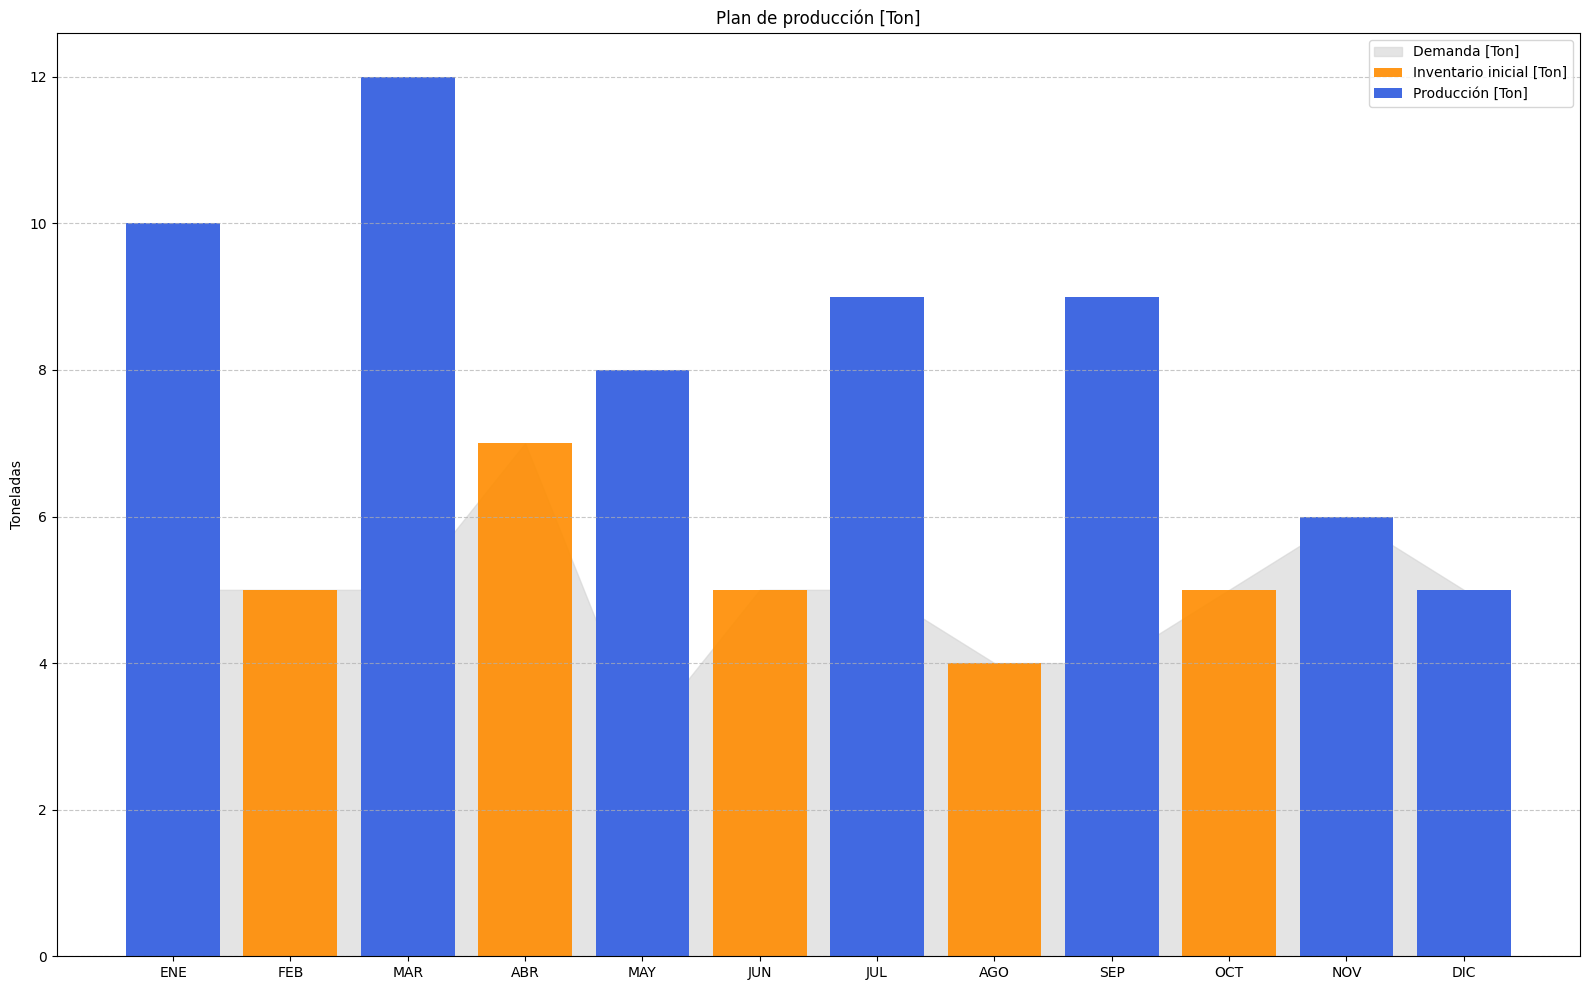

In [46]:
import matplotlib.pyplot as plt

if len(M) <= 12:
    meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
    meses = meses[:len(M)]
else:
    meses = [f"M{i}" for i in M]

# Extraer datos en listas
demanda_list = [d[t] for t in M]
produccion_list = [produccion[t] for t in M]
inventario_list = [inventario[t] for t in M]

# Graficar correctamente con barras apiladas
plt.figure(figsize=(16, 10))

# Área de la demanda
plt.fill_between(meses, demanda_list, color='lightgray', label='Demanda [Ton]', alpha=0.6)

# Barras apiladas: producción sobre inventario inicial
plt.bar(meses, inventario_list, label='Inventario inicial [Ton]', color='darkorange', alpha=0.9)
plt.bar(meses, produccion_list, bottom=inventario_list, label='Producción [Ton]', color='royalblue')

plt.title('Plan de producción [Ton]')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Resultados

In [47]:
import pandas as pd

# -- Crear DataFrame desde la lista de resultados --
df_resultados = pd.DataFrame(resultados)

# -- Establecer 'Método' como índice --
df_resultados.set_index("Método", inplace=True)

# -- Ordenar por empleos generados (de mayor a menor) --
df_resultados.sort_values("Costo Total", ascending=True, inplace=True)

# -- Visualizar resultados ordenados --
df_resultados

,Costo Total,Costo producir,Costo inventario,Ton pedidas (total),Inventario(total),Tiempo (s)
Método,,,,,,
LP,410.330,379.280,31.05,59.0,17.0,0.039316
Policy iteration,410.330,379.280,31.05,59.0,17.0,0.012064
Value iteration,410.330,379.280,31.05,59.0,17.0,0.051178
Policy evaluation,441.360,441.360,0.00,59.0,0.0,0.002452
"(s,S)",455.425,445.455,9.97,59.0,2.5,0.000028
Silver-Meal,502.540,414.770,87.77,59.0,26.0,0.000056
EOQ,708.300,420.370,287.93,59.0,60.0,0.000039


In [48]:
# -- Tomar la solución base de referencia (LP) --
base_lp = df_resultados.loc["LP"]

# -- Calcular el GAP porcentual relativo al método LP (excepto para Tiempo) --
gap_df = ((df_resultados - base_lp) / base_lp) * 100

# -- Reemplazar la columna de tiempo con "x veces LP" en lugar de porcentaje --
tiempo_ratio = (df_resultados["Tiempo (s)"] / base_lp["Tiempo (s)"]).round(4)

# -- Redondear GAPs a 3 decimales --
gap_df = gap_df.round(3)

# -- Renombrar columnas GAP --
gap_df.columns = [col + " GAP (%)" for col in gap_df.columns]

# -- Reemplazar columna de tiempo con "x veces LP" --
gap_df["Tiempo (s) (x veces LP)"] = tiempo_ratio

# -- Eliminar columna anterior de GAP de tiempo --
gap_df = gap_df.drop(columns=["Tiempo (s) GAP (%)"])

# -- Mostrar tabla --
gap_df

,Costo Total GAP (%),Costo producir GAP (%),Costo inventario GAP (%),Ton pedidas (total) GAP (%),Inventario(total) GAP (%),Tiempo (s) (x veces LP)
Método,,,,,,
LP,0.000,0.000,0.000,0.0,0.000,1.0000
Policy iteration,0.000,0.000,0.000,0.0,0.000,0.3069
Value iteration,0.000,0.000,0.000,0.0,0.000,1.3017
Policy evaluation,7.562,16.368,-100.000,0.0,-100.000,0.0624
"(s,S)",10.990,17.448,-67.890,0.0,-85.294,0.0007
Silver-Meal,22.472,9.357,182.673,0.0,52.941,0.0014
EOQ,72.617,10.834,827.311,0.0,252.941,0.0010
